In [ ]:

display(dbutils.fs.ls("/mnt/solargridblob"))

path,name,size,modificationTime
dbfs:/mnt/solargridblob/climate_change_data.csv,climate_change_data.csv,1669507,1732032184000


In [ ]:
# Carregar o dataset do Blob Storage
df = spark.read.csv("/mnt/solargridblob/climate_change_data.csv", header=True, inferSchema=True)

# Mostrar as primeiras linhas
df.show(5)

# Exibir o esquema
df.printSchema()

# Estatísticas descritivas
df.describe().show()


+--------------------+----------------+-------------+------------------+------------------+--------------------+------------------+------------------+------------------+
|                Date|        Location|      Country|       Temperature|     CO2 Emissions|      Sea Level Rise|     Precipitation|          Humidity|        Wind Speed|
+--------------------+----------------+-------------+------------------+------------------+--------------------+------------------+------------------+------------------+
| 2000-01-01 00:00:00| New Williamtown|       Latvia|10.688985961440224|  403.118902532313|  0.7175060280487084|13.835236935170093|23.631256224753127|18.492026001060687|
|2000-01-01 20:09:...|    North Rachel| South Africa|13.814430285994883|396.66349928864787|   1.205714577973989| 40.97408400927044|43.982945512578134| 34.24929982477023|
|2000-01-02 16:19:...|West Williamland|French Guiana| 27.32371775936091| 451.5531550541853|-0.16078297043172432| 42.69793130058377| 96.65259963507044|

In [ ]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- CO2 Emissions: double (nullable = true)
 |-- Sea Level Rise: double (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed: double (nullable = true)



In [ ]:
df.describe().show()

+-------+-----------+-----------+------------------+-----------------+--------------------+--------------------+------------------+--------------------+
|summary|   Location|    Country|       Temperature|    CO2 Emissions|      Sea Level Rise|       Precipitation|          Humidity|          Wind Speed|
+-------+-----------+-----------+------------------+-----------------+--------------------+--------------------+------------------+--------------------+
|  count|      10000|      10000|             10000|            10000|               10000|               10000|             10000|               10000|
|   mean|       null|       null| 14.93603377863015|400.2204688976376|-0.00315168548374...|   49.88120758239161|49.771301928591484|  25.082065534372408|
| stddev|       null|       null| 5.030615849200168| 49.6969327066168|  0.9913486683740705|  28.862417088869915| 28.92932002726051|    14.4666480385455|
|    min|  Aaronberg|Afghanistan|-3.803588598564197|182.1312203487651|  -4.0921549

In [ ]:
# Converter para Pandas para calcular correlações
df_pandas = df.toPandas()
correlation_matrix = df_pandas.corr()

print(correlation_matrix)


                Temperature  CO2 Emissions  Sea Level Rise  Precipitation  \
Temperature        1.000000      -0.002775        0.011663       0.004916   
CO2 Emissions     -0.002775       1.000000       -0.004751      -0.007443   
Sea Level Rise     0.011663      -0.004751        1.000000      -0.000249   
Precipitation      0.004916      -0.007443       -0.000249       1.000000   
Humidity          -0.015737      -0.003661       -0.007610       0.003732   
Wind Speed         0.021779      -0.003990        0.011789      -0.018798   

                Humidity  Wind Speed  
Temperature    -0.015737    0.021779  
CO2 Emissions  -0.003661   -0.003990  
Sea Level Rise -0.007610    0.011789  
Precipitation   0.003732   -0.018798  
Humidity        1.000000    0.028591  
Wind Speed      0.028591    1.000000  


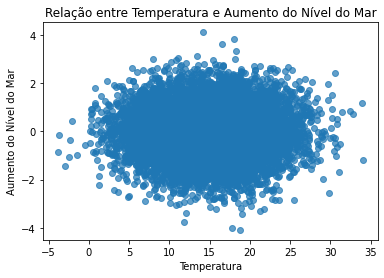

In [ ]:
import matplotlib.pyplot as plt
# Criar um gráfico de dispersão para relacionar temperatura e aumento do nível do mar

plt.scatter(df_pandas["Temperature"], df_pandas["Sea Level Rise"], alpha=0.7)
plt.title("Relação entre Temperatura e Aumento do Nível do Mar")
plt.xlabel("Temperatura")
plt.ylabel("Aumento do Nível do Mar")
plt.show()


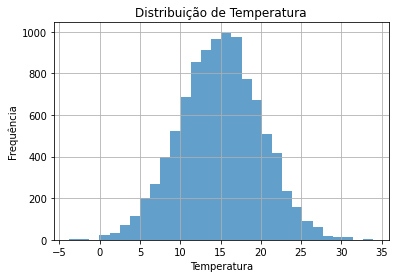

In [ ]:
# Histograma mostrando distribuição de Frequências das Temperaturas
df_pandas["Temperature"].hist(bins=30, alpha=0.7)
plt.title("Distribuição de Temperatura")
plt.xlabel("Temperatura")
plt.ylabel("Frequência")
plt.show()


In [ ]:
from pyspark.sql.functions import year

# Adicionar uma coluna de ano
df = df.withColumn("Year", year("Date"))

# Agrupar por ano e calcular a média
df.groupBy("Year").avg("Sea Level Rise").show()


+----+--------------------+
|Year| avg(Sea Level Rise)|
+----+--------------------+
|2003|0.033170526117594225|
|2007| 0.05235115125142207|
|2018| 0.05091619098201069|
|2015|  0.0172197749632445|
|2006| -0.0421065910516791|
|2022|-0.00201331002750...|
|2013|-0.00493550172806...|
|2014| 0.05126234314088981|
|2019| -0.0329682443711795|
|2004| 0.09811426462619739|
|2020|-0.05568564539748...|
|2012|-0.07325312749586939|
|2009|-0.07191149160687238|
|2016|-0.03944828492901061|
|2001|0.021330949511707095|
|2005|-0.02854530109231...|
|2000| 0.06677902371759098|
|2010| 0.04973530879173803|
|2011|-0.00179115121625562|
|2008|-0.13764484625473306|
+----+--------------------+
only showing top 20 rows



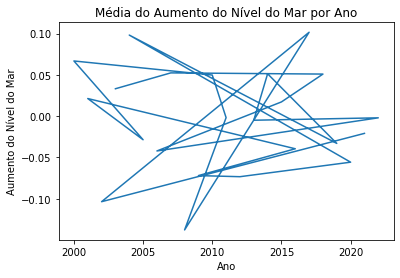

In [ ]:
#avg_sea_level = df.groupBy("Year").avg("Sea Level Rise").toPandas()
#plt.plot(avg_sea_level["Year"], avg_sea_level["avg(Sea Level Rise)"])
#plt.title("Média do Aumento do Nível do Mar por Ano")
#plt.xlabel("Ano")
#plt.ylabel("Aumento do Nível do Mar")
#plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Selecionar features
assembler = VectorAssembler(
    inputCols=["Temperature", "CO2 Emissions", "Precipitation", "Humidity", "Wind Speed"],
    outputCol="features"
)
df_features = assembler.transform(df).select("features", "Sea Level Rise")

# Treinar modelo de regressão
lr = LinearRegression(featuresCol="features", labelCol="Sea Level Rise")
lr_model = lr.fit(df_features)

# Exibir métricas
print(f"Coeficiente: {lr_model.coefficients}")
print(f"Intercepto: {lr_model.intercept}")
print(f"R2: {lr_model.summary.r2}")


Coeficiente: [0.0022213218540691783,-9.379371017418392e-05,-3.0720775452711987e-06,-0.0002667894873169441,0.0008048798906575228]
Intercepto: -0.005547612166171338
R2: 0.0003515424484459295


In [ ]:
pip install pymongo

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
pip install azure-cosmos


Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
from azure.cosmos import CosmosClient
import json
import uuid

# Configuração do Cosmos DB
ENDPOINT = "https://solargridcosmosdb.documents.azure.com:443/"
PRIMARY_KEY = "<<my_COSMOSDB_KEY>>"
DB_NAME = "solargriddb"
COLLECTION_NAME = "ProcessedClimateData"

# Conectar ao Cosmos DB
client = CosmosClient(ENDPOINT, PRIMARY_KEY)
database = client.get_database_client(DB_NAME)
container = database.get_container_client(COLLECTION_NAME)

# Carregar o dataset do Blob Storage
df = spark.read.csv("/mnt/solargridblob/climate_change_data.csv", header=True, inferSchema=True)
df.show(5)

# Converter o DataFrame Spark para Pandas
df_pandas = df.select("Temperature", "CO2 Emissions", "Sea Level Rise", "Precipitation", "Humidity", "Wind Speed").toPandas()

# Inserir os documentos no Cosmos DB
for _, row in df_pandas.iterrows():
    document = row.to_dict()  # Converte cada linha em um dicionário
    document["id"] = str(uuid.uuid4())  # Adiciona um campo 'id' único
    try:
        container.create_item(body=document)
        print(f"Document inserted: {document}")
    except Exception as e:
        print(f"Error inserting document: {e}")


+--------------------+----------------+-------------+------------------+------------------+--------------------+------------------+------------------+------------------+
|                Date|        Location|      Country|       Temperature|     CO2 Emissions|      Sea Level Rise|     Precipitation|          Humidity|        Wind Speed|
+--------------------+----------------+-------------+------------------+------------------+--------------------+------------------+------------------+------------------+
| 2000-01-01 00:00:00| New Williamtown|       Latvia|10.688985961440224|  403.118902532313|  0.7175060280487084|13.835236935170093|23.631256224753127|18.492026001060687|
|2000-01-01 20:09:...|    North Rachel| South Africa|13.814430285994883|396.66349928864787|   1.205714577973989| 40.97408400927044|43.982945512578134| 34.24929982477023|
|2000-01-02 16:19:...|West Williamland|French Guiana| 27.32371775936091| 451.5531550541853|-0.16078297043172432| 42.69793130058377| 96.65259963507044|